In [1]:
suppressPackageStartupMessages({
    source("../code/process_slim_vcf.R")
    library(ggbeeswarm)
    library(tidyverse)
    library(magrittr)
    library("future")
    plan(multicore)
})

In [2]:
# AF changes over time
gens <- c(seq(10), 20, 50, 100, seq(200, 2200, 200))

In [3]:
# read all Nea/MH deleterious mutations and neutral markers over time
raw_nea_muts <- raw_mh_muts <- raw_region_markers <- raw_gap_markers <- NULL

for (rep_i in 1:3) {

for (gen in gens) {
    vcf <- readVcf(paste0("../data/simulations/exon_h_0.5_rep_", rep_i, "_gen_", gen, ".vcf.gz"))

    raw_region_markers %<>% bind_rows(get_markers(vcf, "../data/slim_coords/exon_all_sites.bed", within_region="region", fill_freq=FALSE) %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
    raw_gap_markers %<>% bind_rows(get_markers(vcf, "../data/slim_coords/exon_all_sites.bed", within_region="gap", fill_freq=FALSE) %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows    

    raw_mh_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=1, t_min=70000) %>% as.data.frame %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
    raw_nea_muts %<>% bind_rows(mut_info(vcf, mut_type=0, pop_origin=2, t_min=70000) %>% as.data.frame %>% .[c("MID", "S", "freq")] %>% mutate(gen=gen, rep=rep_i, MID=paste0(rep, "_", MID))) %>% bind_rows
}

}

In [4]:
# fix this to that freqs are added only to the very end of the data.frame
complete_mut <- function(df) {
    # we want to know the frequency of a mutation at least in first X generations
    # (otherwise just kick out the mutation completelu)
    minimum_gen <- gens[1:10]
    if (length(intersect(df$gen, minimum_gen)) != length(minimum_gen)) return(NULL)

    # we have an information about the freq in the very last generation already
    if (df[nrow(df), "gen"] == gens[length(gens)]) return(df)

    empty_gen <- data.frame(gen=gens[(which(gens == max(df$gen)) + 1) : length(gens)])
    bind_rows(df[c("freq", "gen")], empty_gen) %>% 
        replace_na(list(freq=0)) %>%
        mutate(MID=df$MID[1], S=df$S[1], rep=df$rep[1]) %>%
        .[c("MID", "S", "freq", "gen", "rep")]
}

### Complete the mutation dataframes for mutations that get lost

In [5]:
nea_muts %<-% { raw_nea_muts %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="Nea_del") %>% as_tibble }

In [6]:
mh_muts %<-% { raw_mh_muts %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="MH_del") %>% as_tibble }

In [7]:
gap_markers %<-% { raw_gap_markers %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="gap_marker") %>% as_tibble }

In [8]:
region_markers %<-% { raw_region_markers %>% split(., .[["MID"]]) %>% lapply(complete_mut) %>% compact %>% bind_rows %>% mutate(mut_type="region_marker") %>% as_tibble }

### Trajectories of different mutation types

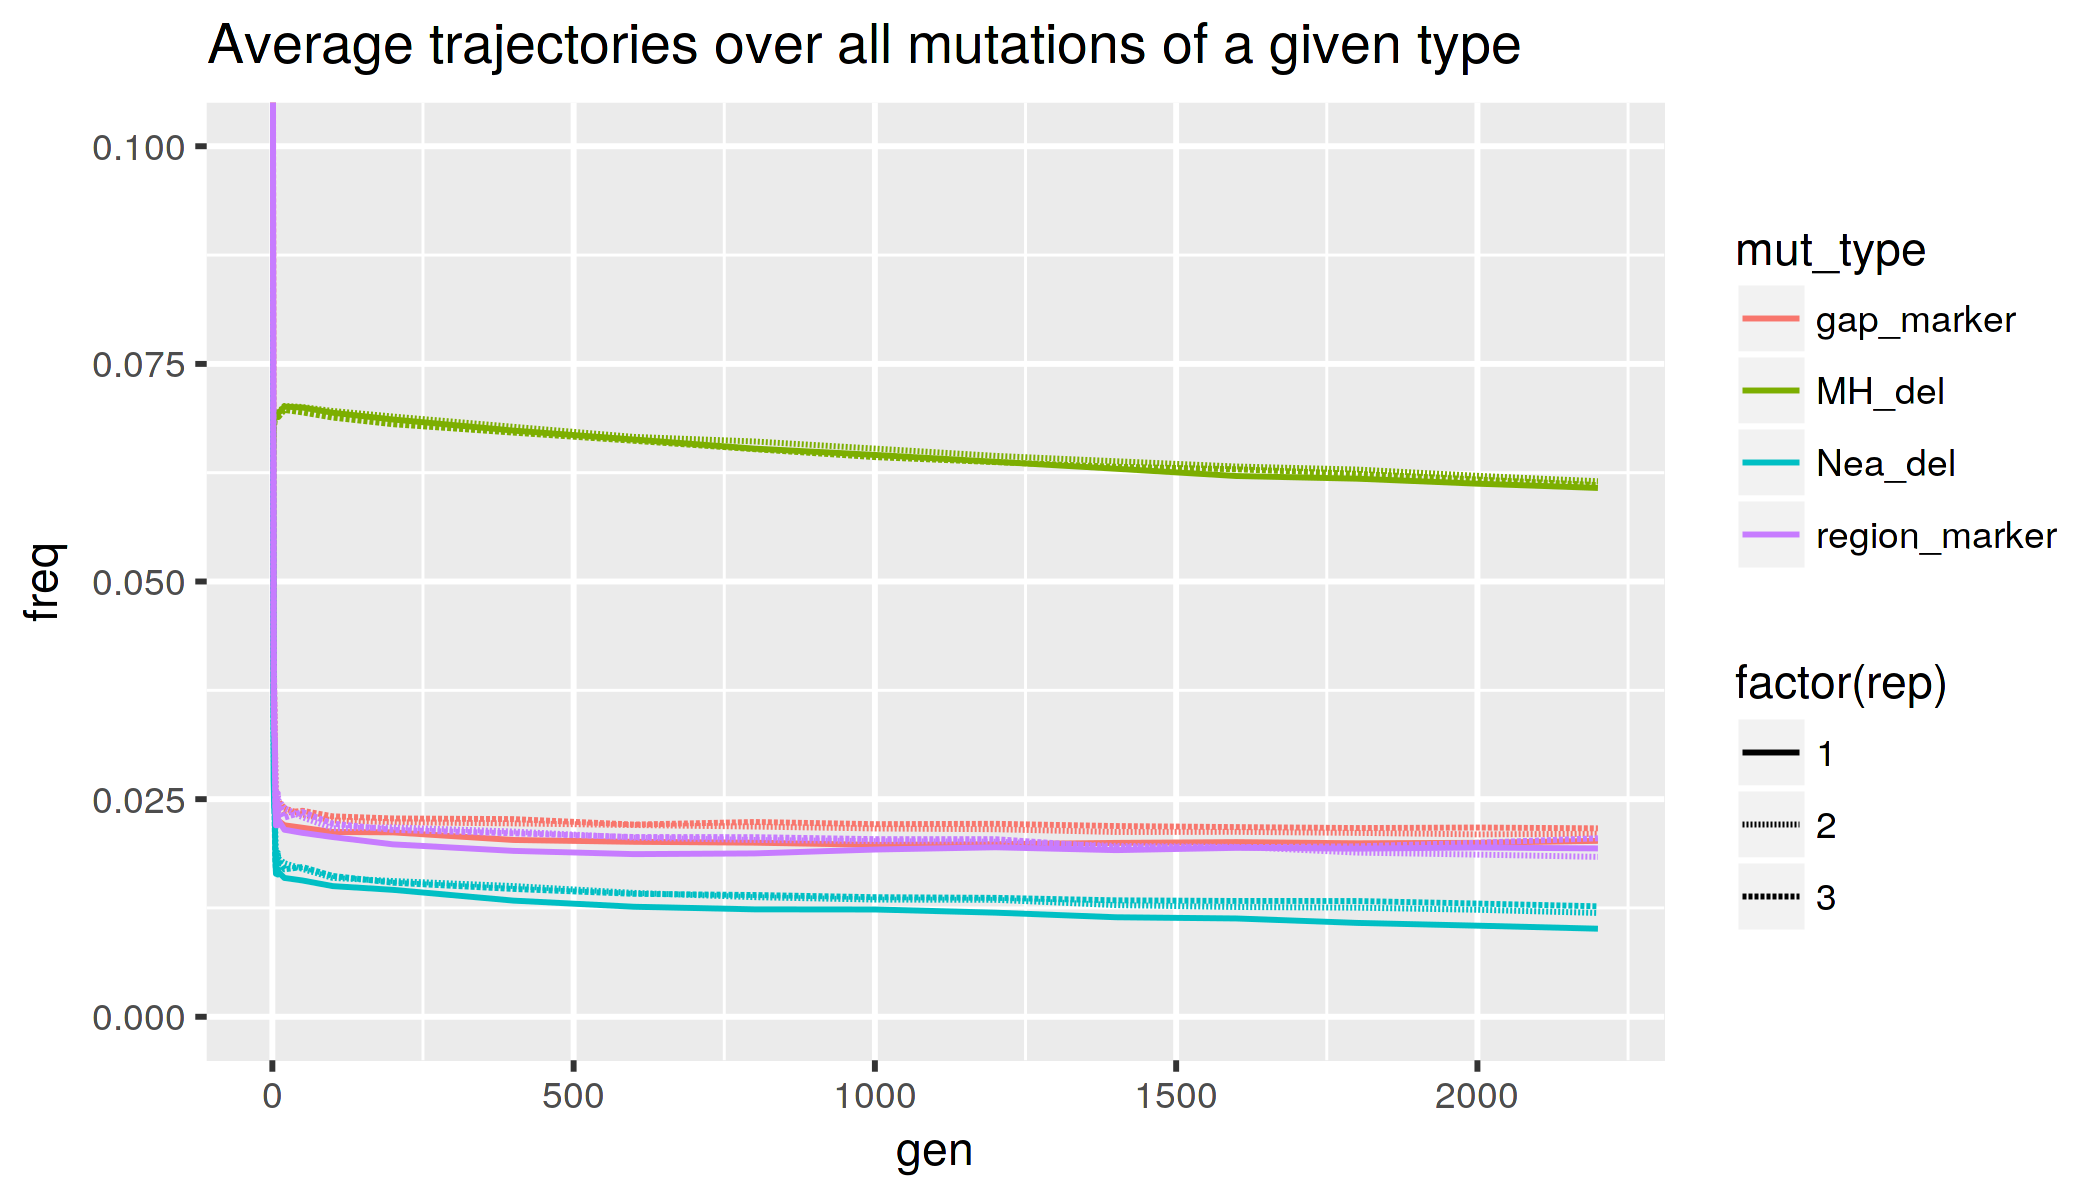

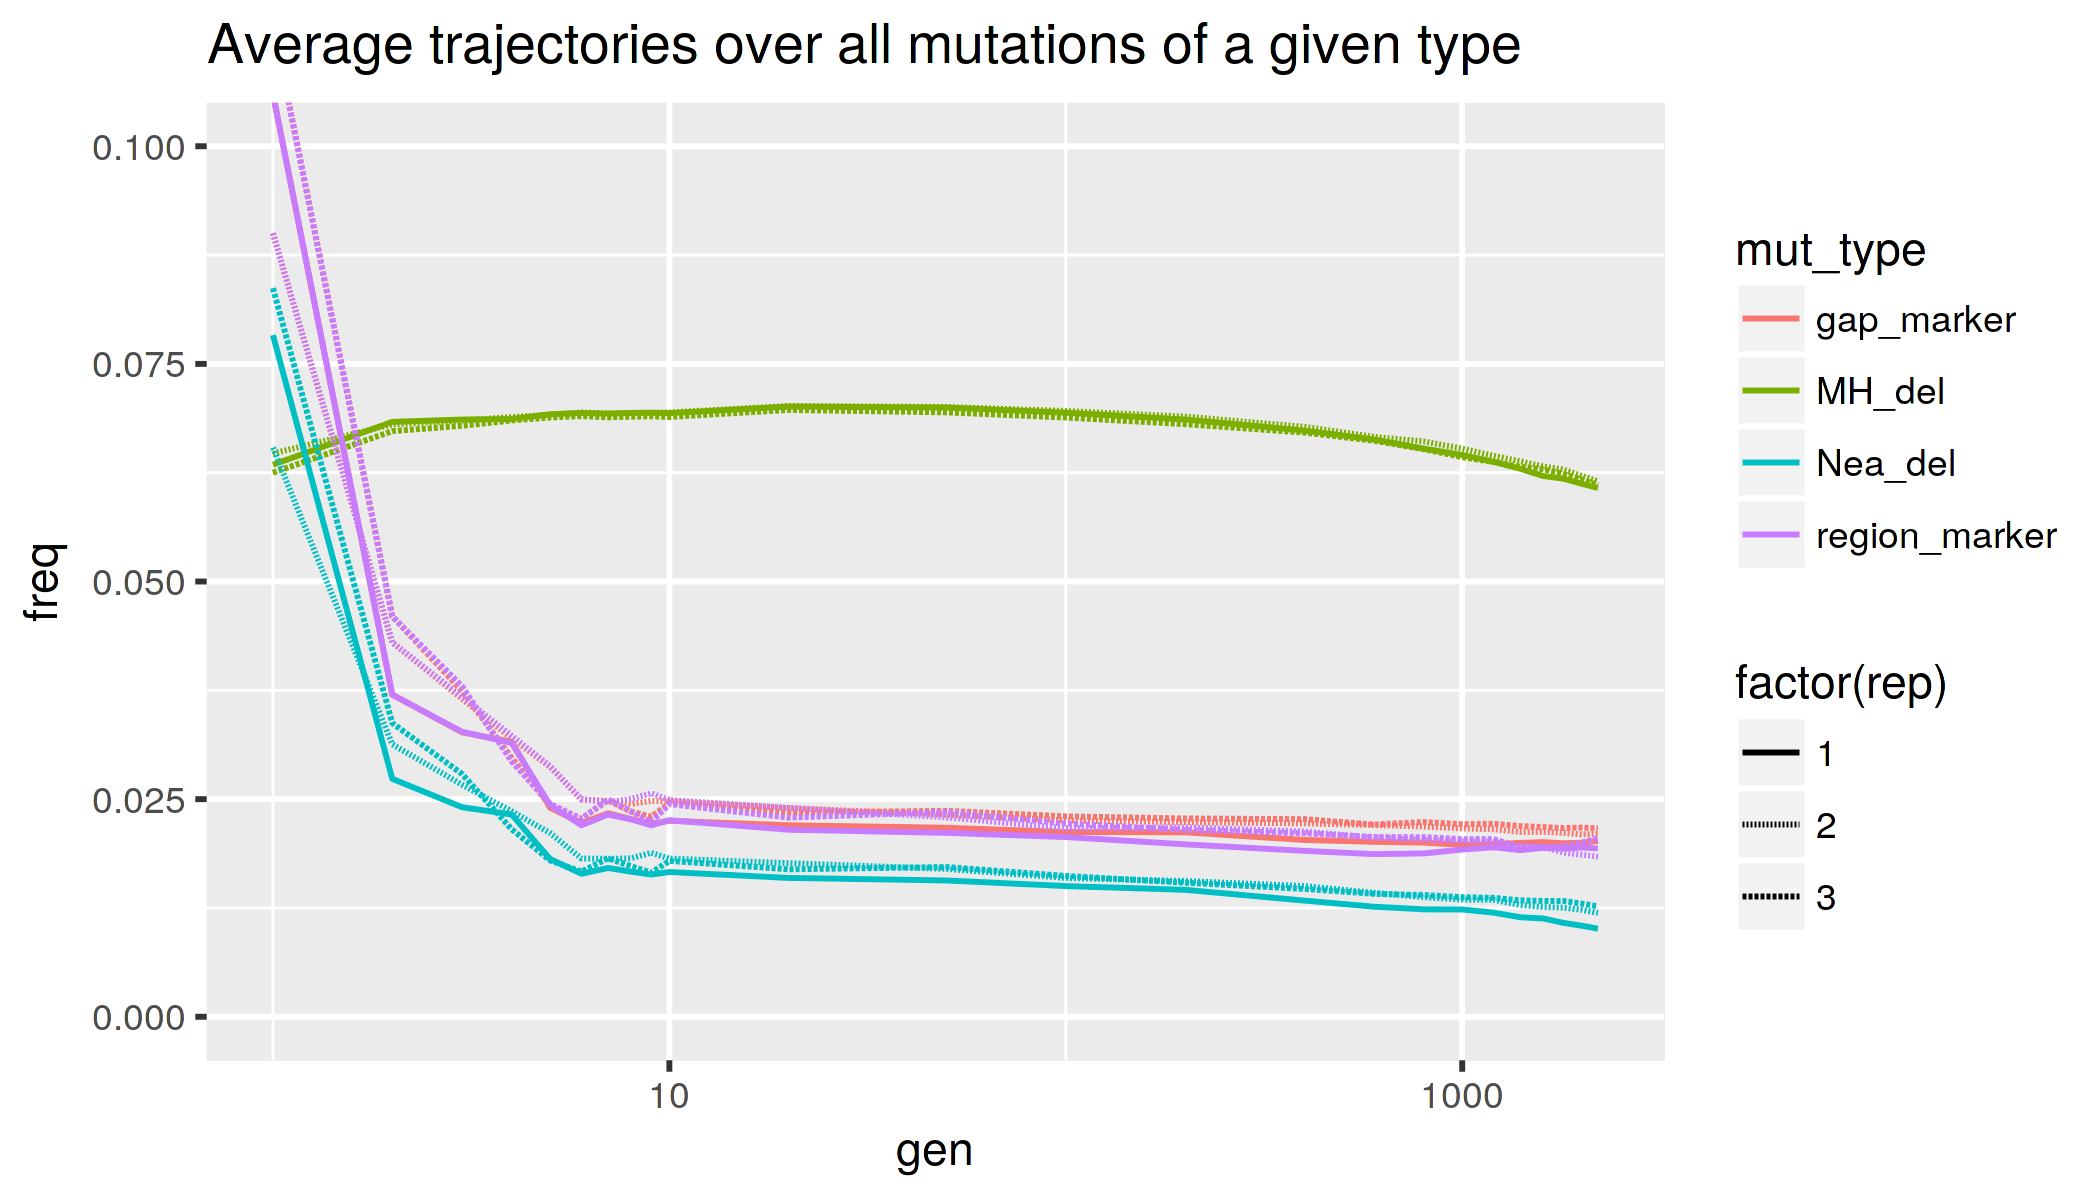

In [10]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=300)

bind_rows(nea_muts, mh_muts, gap_markers, region_markers) %>%
    group_by(gen, rep, mut_type) %>% summarise(freq=mean(freq)) %>% 
    ggplot(aes(gen, freq, color=mut_type, linetype=factor(rep))) +
    geom_line() +
    coord_cartesian(y=c(0, 0.1)) +
    ggtitle("Average trajectories over all mutations of a given type")

bind_rows(nea_muts, mh_muts, gap_markers, region_markers) %>%
    group_by(gen, rep, mut_type) %>% summarise(freq=mean(freq)) %>% 
    ggplot(aes(gen, freq, color=mut_type, linetype=factor(rep))) +
    geom_line() +
    coord_cartesian(y=c(0, 0.1)) + scale_x_log10() +
    ggtitle("Average trajectories over all mutations of a given type")

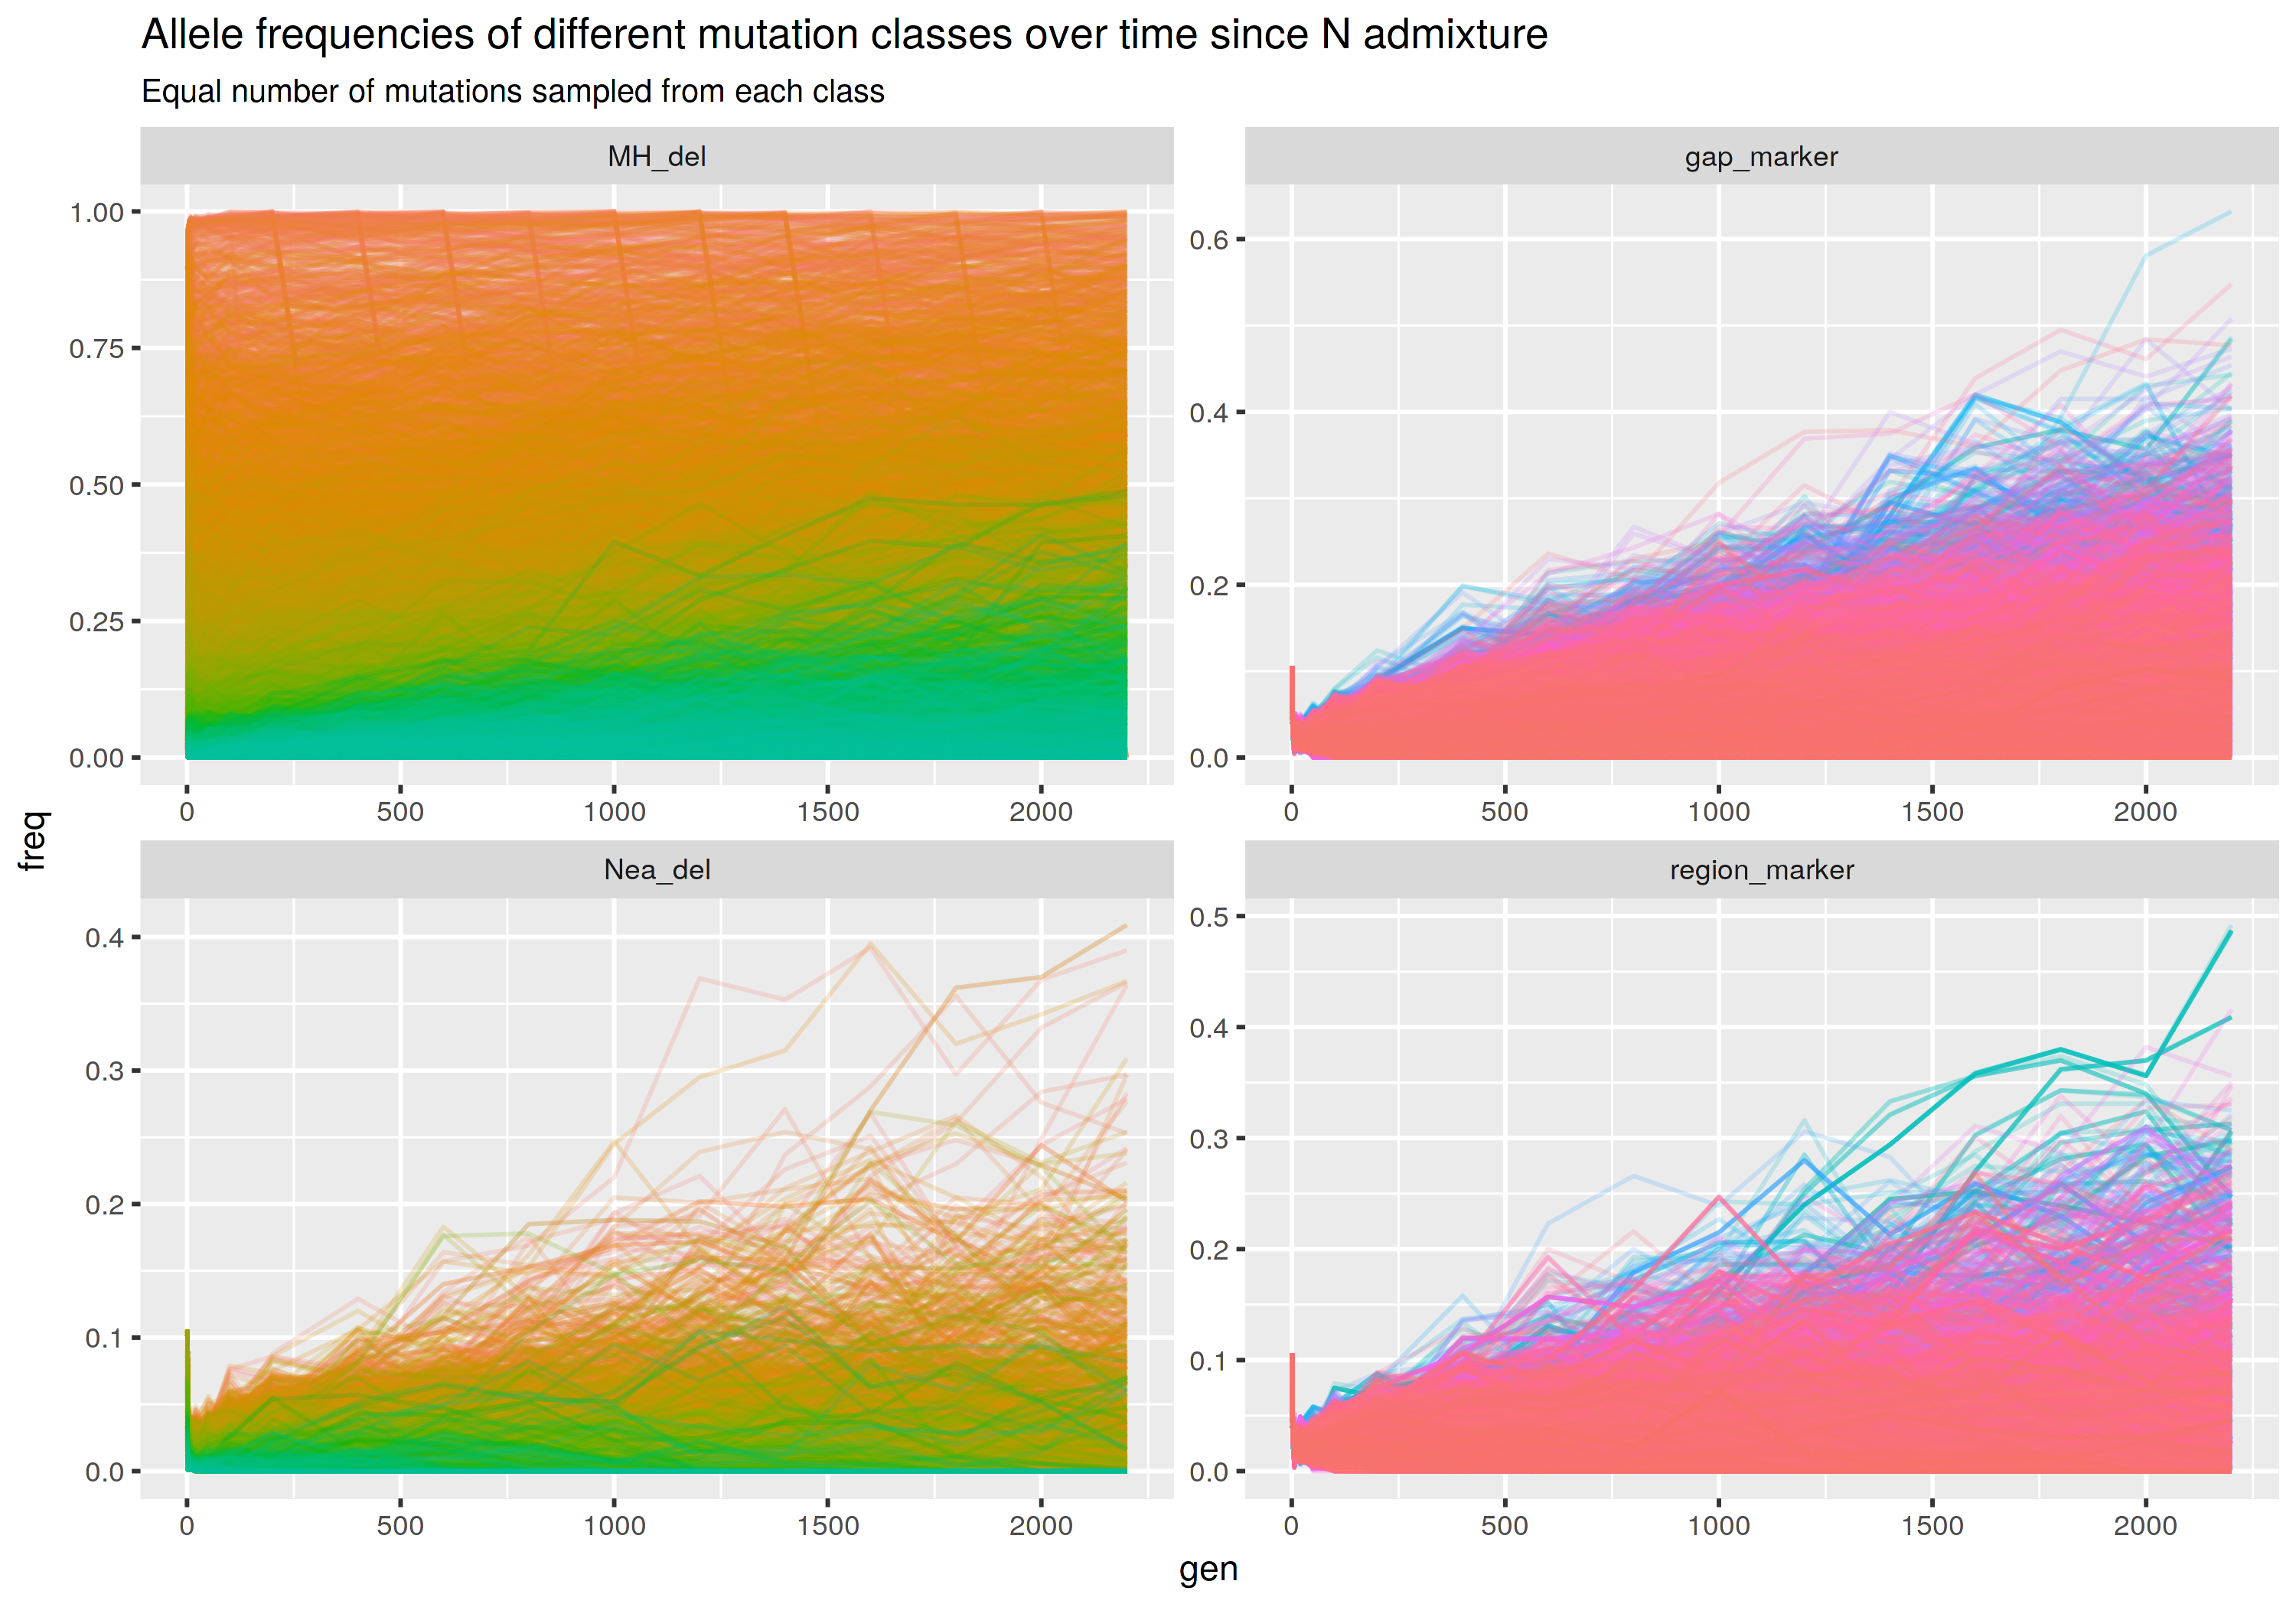

In [13]:
options(repr.plot.width=10, repr.plot.height=7, repr.plot.res=300)

bind_rows(nea_muts, mh_muts, gap_markers, region_markers) %>%
mutate(mut_type=factor(mut_type, levels=c("MH_del", "gap_marker", "Nea_del", "region_marker"))) %>% 
    filter(rep == 1) %>%
    ggplot(aes(gen, freq, color=factor(MID))) + geom_line(alpha=1/5) +
        facet_wrap(~ mut_type, scales="free") +
        theme(legend.position="none") +
        ggtitle("Allele frequencies of different mutation classes over time since N admixture",
                "Equal number of mutations sampled from each class")

### Calculate frequency deltas

In [48]:
calc_deltas <- function(df) {
    tibble(g=df$gen[2:nrow(df)],
           t=diff(df$gen),
           delta_f=diff(df$freq) / t,
           MID=df$MID[1],
           logS=log10(-df$S[1]),
           mut_type=df$mut_type[1])
}

Set future limit to 900 Mb:

In [22]:
options(future.globals.maxSize= 900*1024^2)

In [16]:
nea_deltas %<-% { nea_muts %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [17]:
mh_deltas %<-% { mh_muts %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [18]:
gap_deltas %<-% { gap_markers %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [19]:
region_deltas %<-% { region_markers %>% split(., .[["MID"]]) %>% lapply(calc_deltas) %>% bind_rows }

In [58]:
deltas <- bind_rows(
  mutate(nea_deltas, mut_type="Nea_del"),
  mutate(mh_deltas, mut_type="MH_del"),
  mutate(gap_deltas, mut_type="gap_marker"),
  mutate(region_deltas, mut_type="region_marker")
) %>%
    select(-t) %>%
    mutate(rep=str_replace(MID, "_[0-9]+$", "")) %>%
    mutate(mut_type=factor(mut_type, levels=c("MH_del", "Nea_del", "gap_marker", "region_marker")))

`geom_smooth()` using method = 'loess'


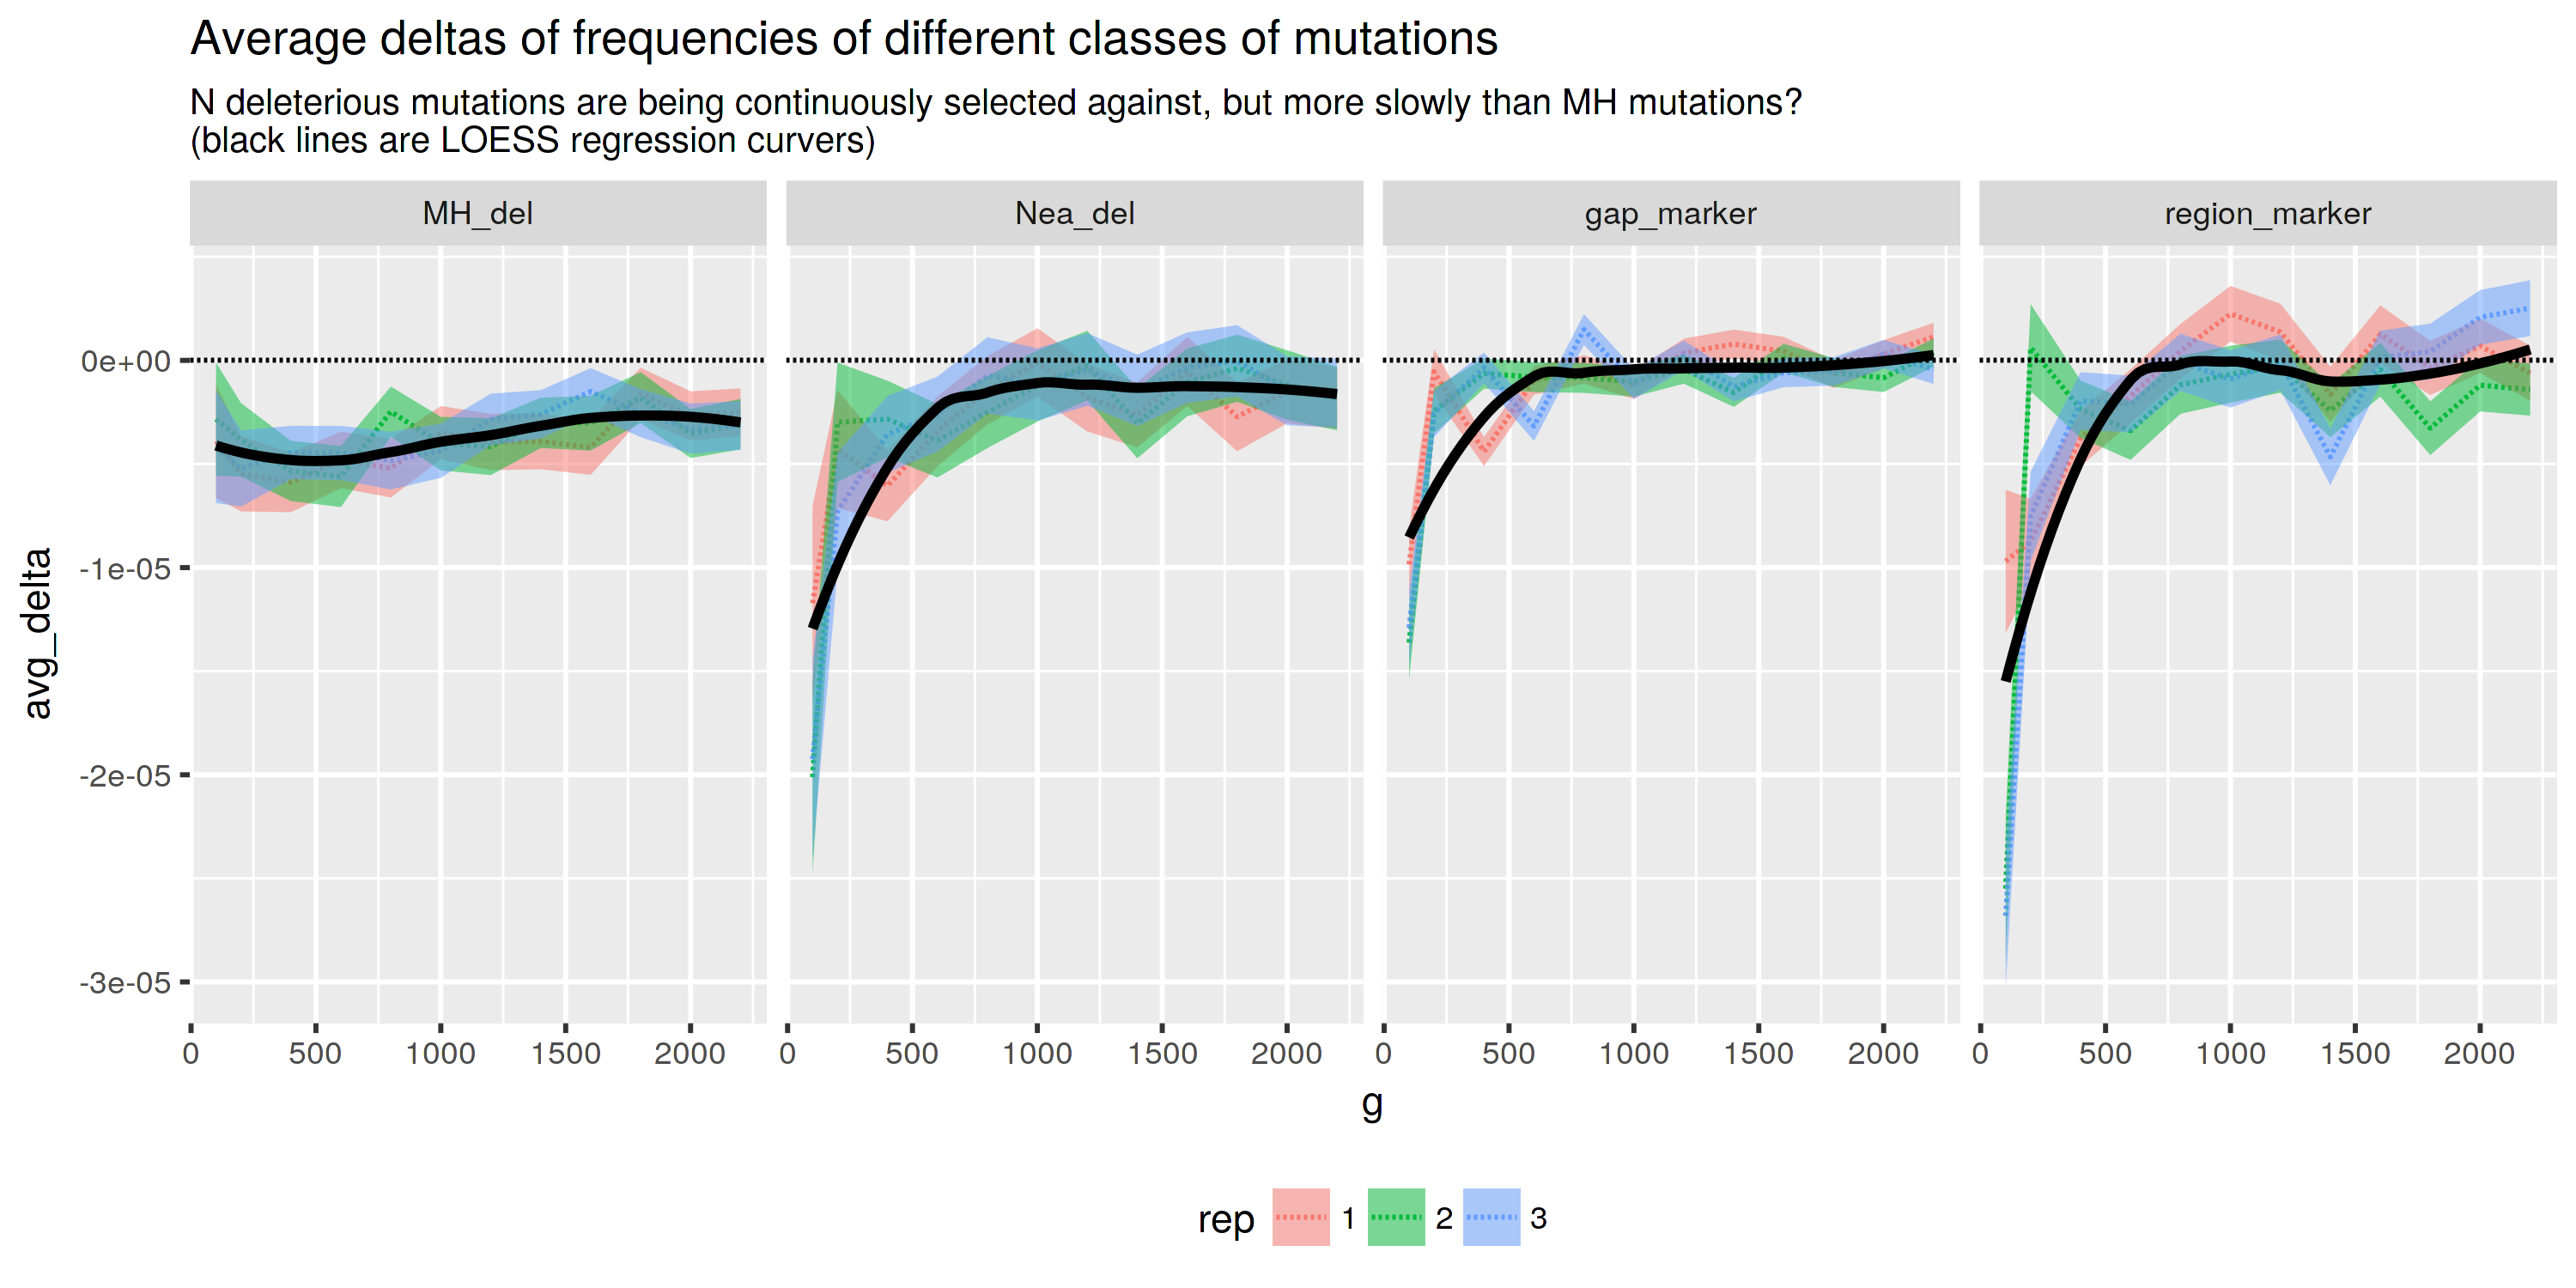

In [59]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

group_by(deltas, g, mut_type, rep) %>%    
    summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
    mutate(se_delta=sd_delta / sqrt(n_delta),
           lower_ci=avg_delta - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
           upper_ci=avg_delta + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
filter(g >= 100) %>% 
ggplot(aes(g, avg_delta)) +
    geom_line(aes(color=rep), linetype=2) +
    geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=1/2) +
    geom_smooth(color="black", alpha=1/2, se=FALSE) + 
    geom_hline(yintercept=0, linetype=2) + facet_grid(. ~ mut_type) +
    theme(legend.position="bottom") +
    ggtitle("Average deltas of frequencies of different classes of mutations",
            "N deleterious mutations are being continuously selected against, but more slowly than MH mutations?
(black lines are LOESS regression curvers)")

`geom_smooth()` using method = 'loess'


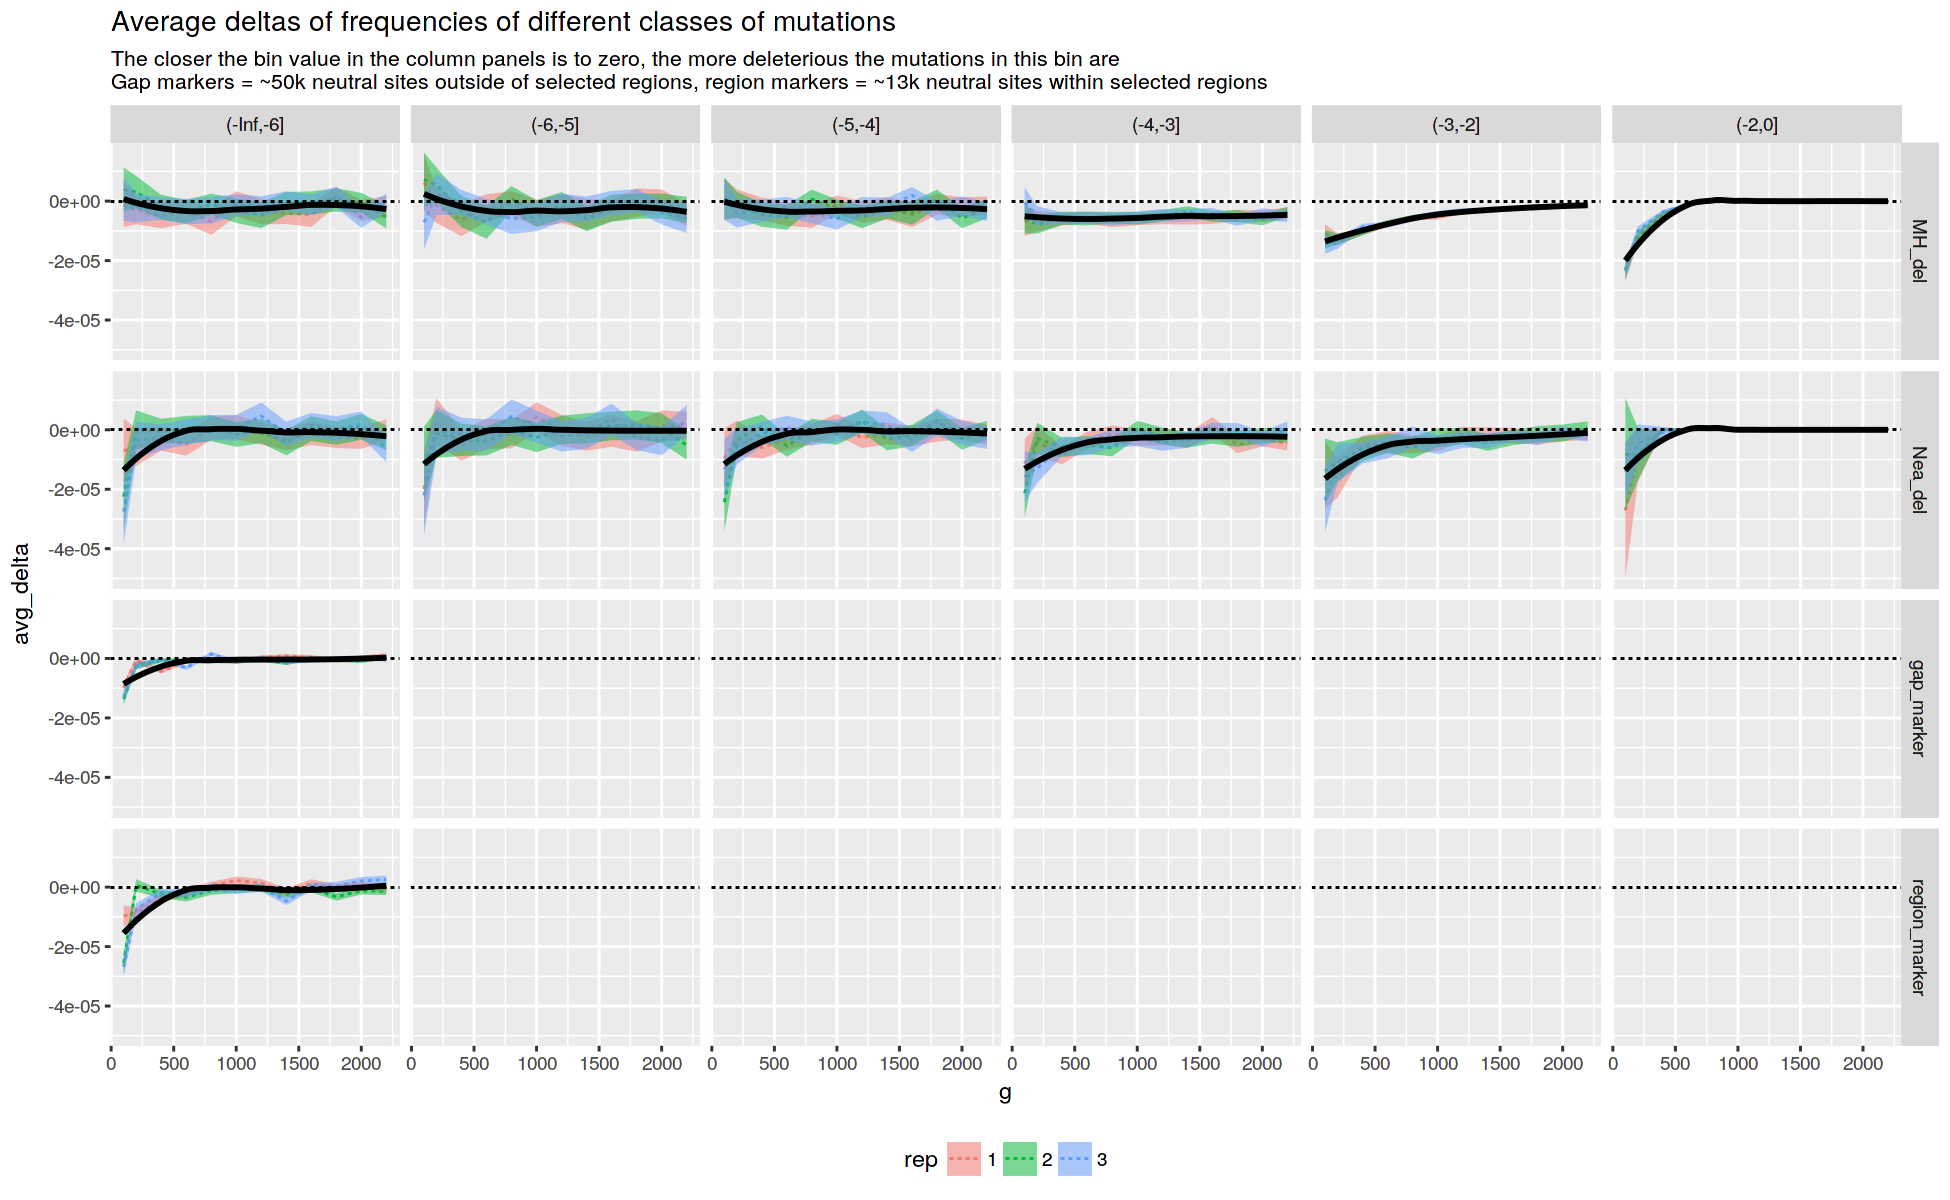

In [64]:
options(repr.plot.width=13, repr.plot.height=8, repr.plot.res=150)

deltas %>% mutate(logS_bin=cut(logS, breaks=c(0, -2, -3, -4, -5, -6, -Inf))) %>%
    replace_na(list(logS_bin="(-Inf,-6]")) %>% 
group_by(g, mut_type, rep, logS_bin) %>%    
    summarise(avg_delta=mean(delta_f), sd_delta=sd(delta_f), n_delta=n()) %>%
    mutate(se_delta=sd_delta / sqrt(n_delta),
           lower_ci=avg_delta - qt(1 - (0.05 / 2), n_delta - 1) * se_delta,
           upper_ci=avg_delta + qt(1 - (0.05 / 2), n_delta - 1) * se_delta) %>% 
filter(g >= 100) %>% 
ggplot(aes(g, avg_delta)) +
    geom_line(aes(color=rep), linetype=2) +
    geom_ribbon(aes(g, ymin=lower_ci, ymax=upper_ci, fill=rep), alpha=1/2) +
    geom_smooth(color="black", alpha=1/2, se=FALSE) + 
    geom_hline(yintercept=0, linetype=2) + facet_grid(mut_type ~ logS_bin) +
    theme(legend.position="bottom") +
    ggtitle("Average deltas of frequencies of different classes of mutations",
            "The closer the bin value in the column panels is to zero, the more deleterious the mutations in this bin are
Gap markers = ~50k neutral sites outside of selected regions, region markers = ~13k neutral sites within selected regions")

<font color="red"><h4>Main point</h4>
Does the trajectory of N ancestry (on neutral markers) level off because the sites become unlinked from the nearby deleterious sequence or because the deleterious sequence simply stops being efficiently removed?</font>

Warning message in rq.fit.br(wx, wy, tau = tau, ...):
“Solution may be nonunique”

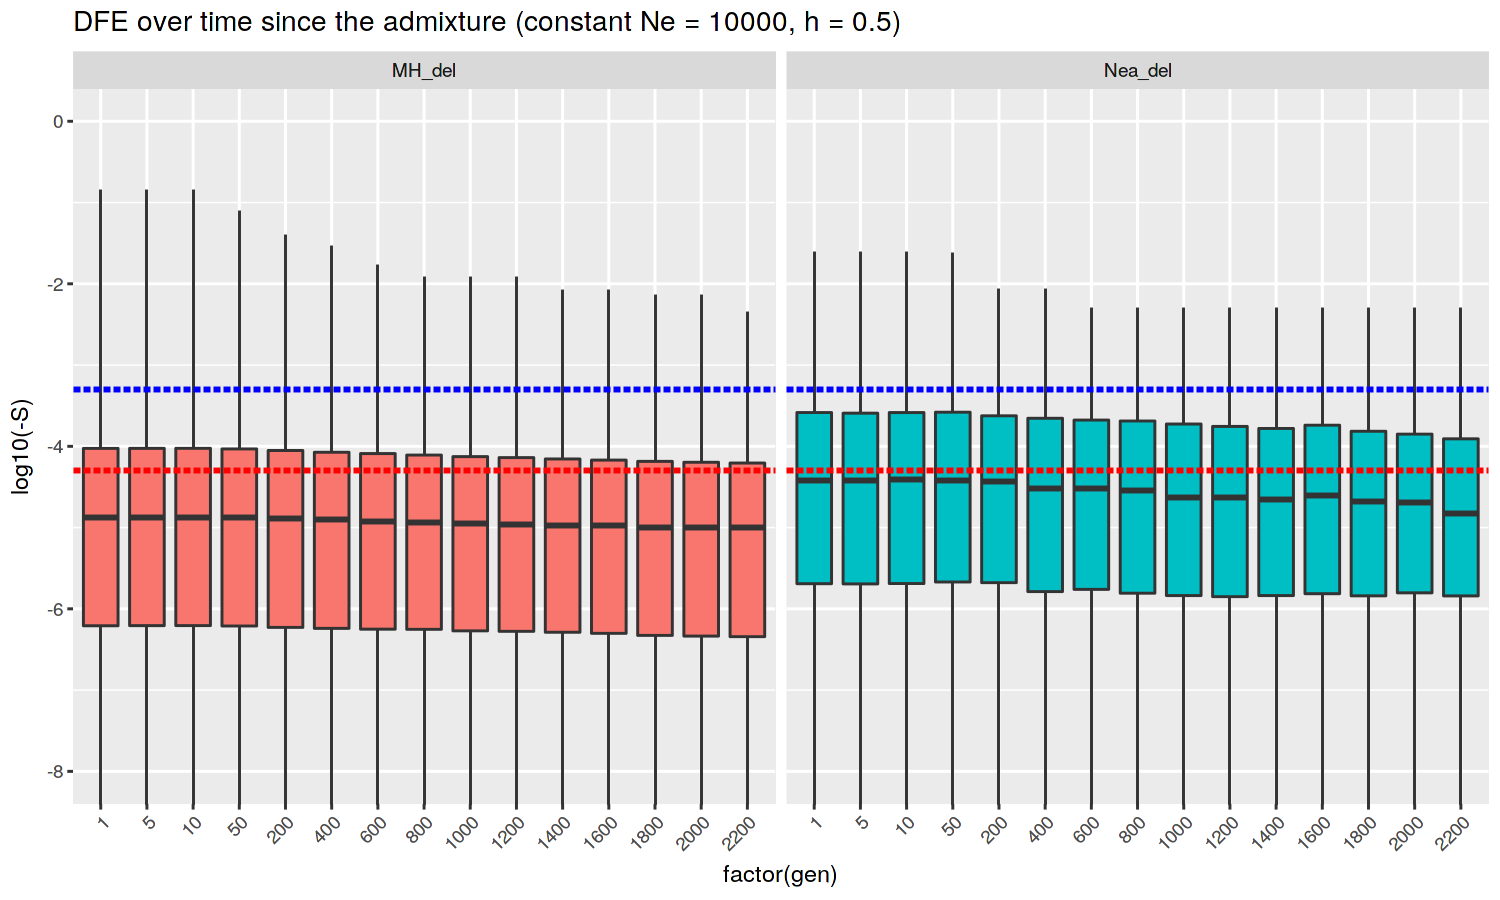

In [67]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>% 
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), fill=mut_type, weight=freq)) +
  geom_boxplot() +
  facet_wrap(~ mut_type) +
  coord_cartesian(y=c(0, -8)) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

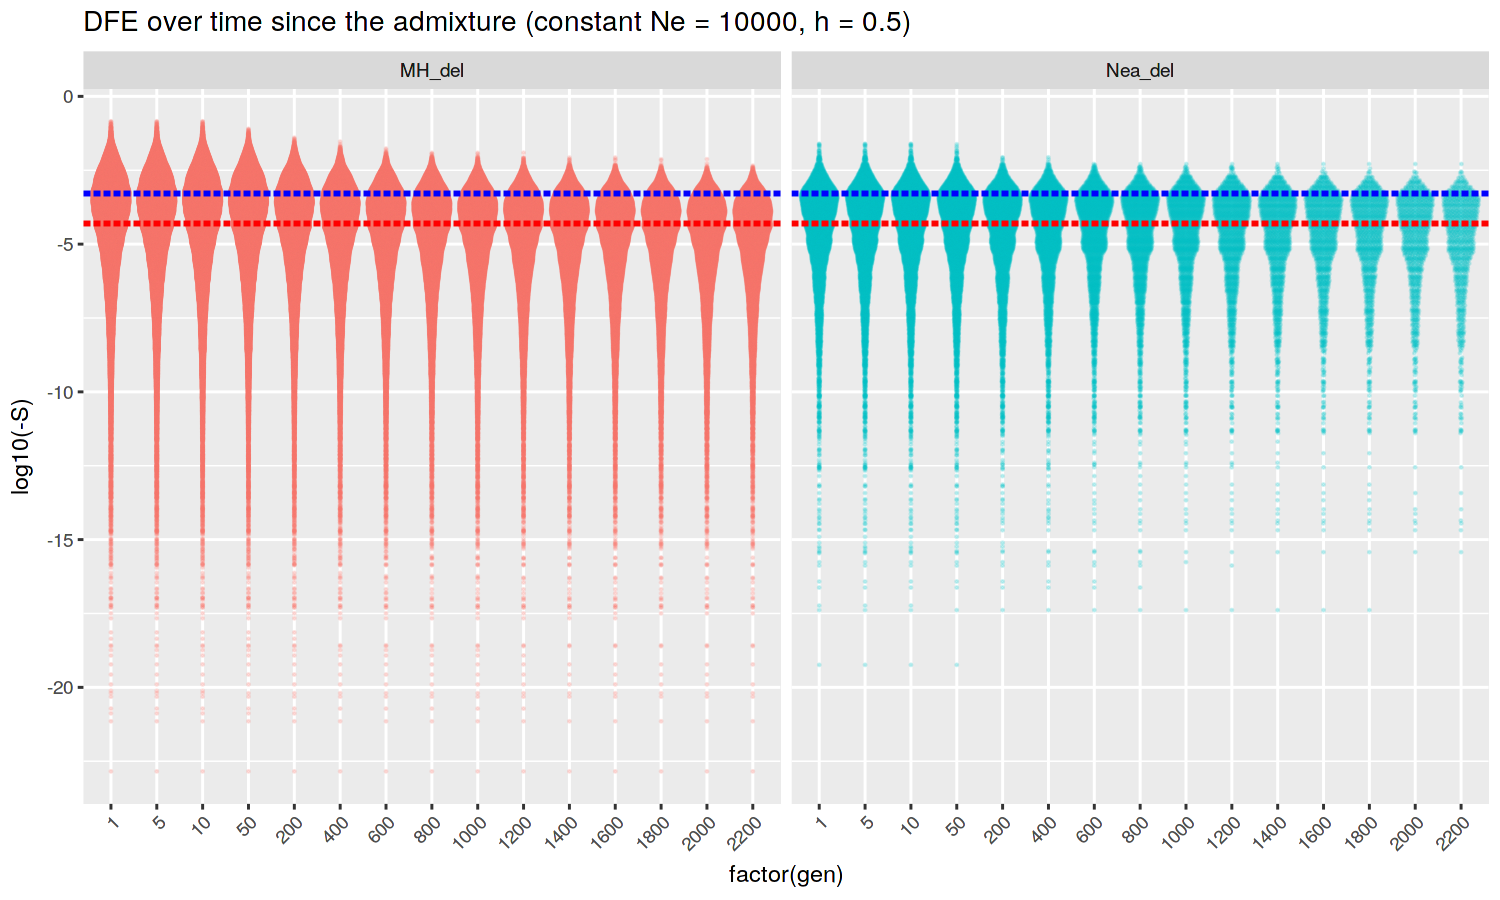

In [68]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>%
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mut_type, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mut_type) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=log10(1/(2*10000)), linetype=5, size=1, color="red") +
  geom_hline(yintercept=log10(1/(2*1000)), linetype=5, size=1, color="blue") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")



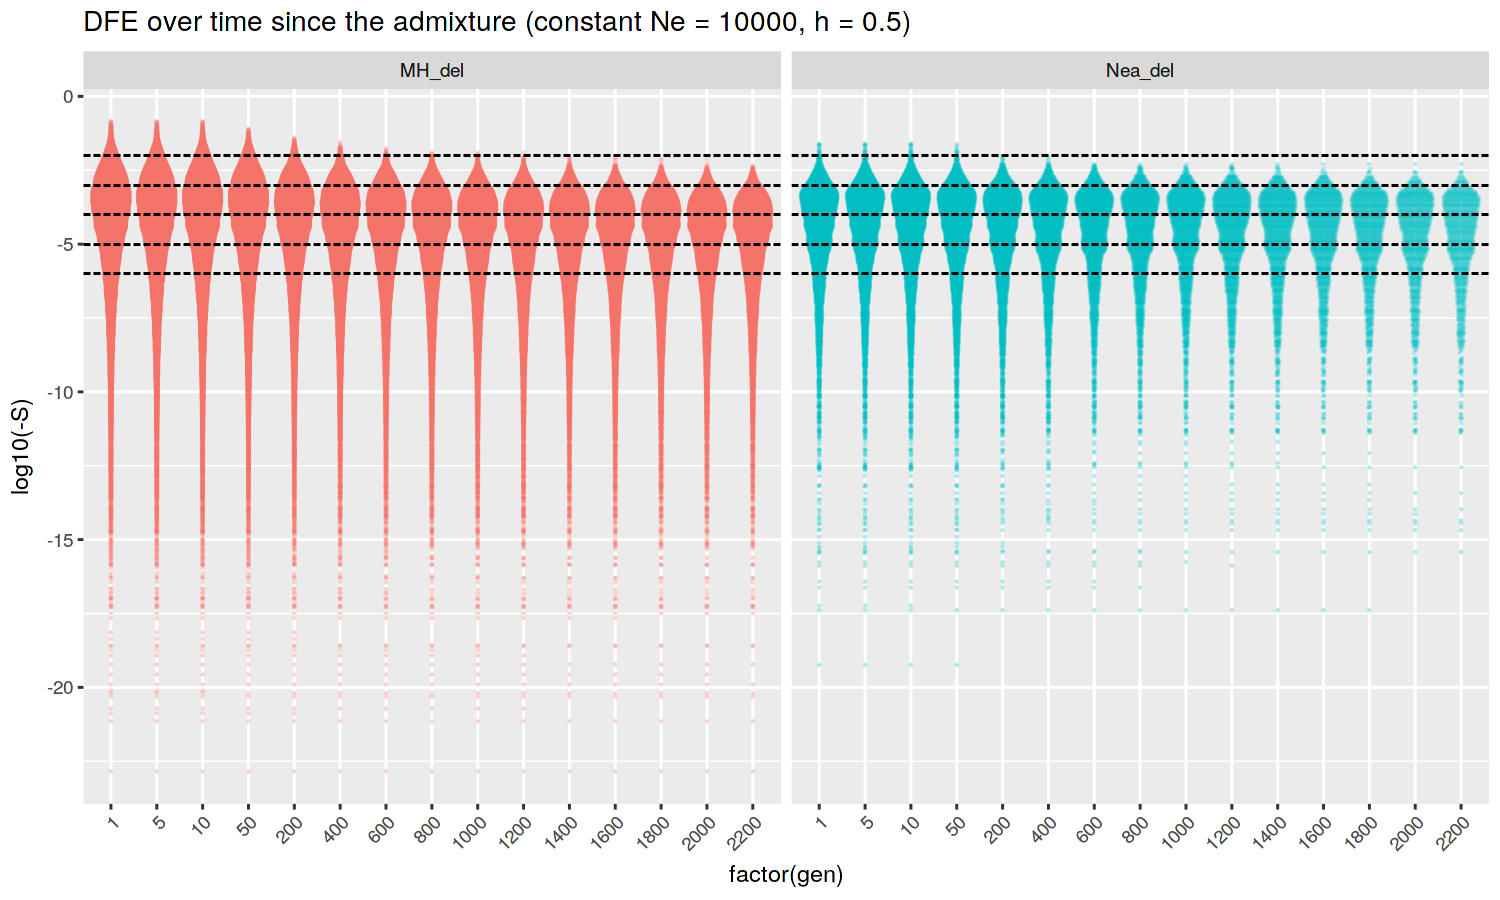

In [69]:
options(repr.plot.width=10, repr.plot.height=6)

# DFE plots
bind_rows(nea_muts, mh_muts) %>%
filter(rep == 1, freq > 0) %>%
filter(gen %in% c(1, 5, 10, 50, seq(200, 2200, 200))) %>% 
ggplot(aes(factor(gen), log10(-S), color=mut_type, weight=freq)) +
  geom_quasirandom(alpha=1/5, size=0.1) +
  facet_wrap(~ mut_type) +
  theme(axis.text.x = element_text(angle=45, hjust=1), legend.position="none") +
  geom_hline(yintercept=c(-2, -3, -4, -5, -6), linetype=5, size=0.5, color="black") +
  labs(title="DFE over time since the admixture (constant Ne = 10000, h = 0.5)")

In [70]:
save.image("../data/RData/selection_efficacy.RData")